<a href="https://colab.research.google.com/github/Ddmon-cyber/NVDA_LSTM_Model/blob/main/NVDA_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install yfinance ONLY (safe in Colab)
!pip -q install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

np.random.seed(42)
tf.random.set_seed(42)
os.makedirs("figs", exist_ok=True)

TICKER = "NVDA"
LOOKBACK = 20         # weeks of history per sample
TEST_WEEKS = 52       # last ~1 year for test
VAL_WEEKS  = 52       # ~1 year for validation prior to test

In [ ]:
df = yf.download(TICKER, start="2016-01-01", interval="1wk",
                 auto_adjust=True, progress=False)
df.columns.tolist()


[('Close', 'NVDA'),
 ('High', 'NVDA'),
 ('Low', 'NVDA'),
 ('Open', 'NVDA'),
 ('Volume', 'NVDA')]

In [ ]:
# WEEKLY data (1wk) from yfinance
df = yf.download(TICKER, start="2016-01-01", interval="1wk",
                 auto_adjust=True, progress=False)

# If columns are MultiIndex like ('Close','NVDA'), drop the ticker level
if isinstance(df.columns, pd.MultiIndex):
    # second level is the ticker (NVDA) -> drop it
    df = df.droplevel(1, axis=1)

# Standardize column names
df.columns = [c.lower().strip() for c in df.columns]

# Keep required OHLCV columns and drop NaNs
needed = ["open", "high", "low", "close", "volume"]
w = df[needed].dropna().copy()

w.head(), w.tail(), w.shape


(                open      high       low     close      volume
 Date                                                          
 2016-01-01  0.787680  0.815733  0.728891  0.738648  1942996000
 2016-01-08  0.748162  0.748894  0.678639  0.699374  2359108000
 2016-01-15  0.671321  0.694008  0.645220  0.678152  2261228000
 2016-01-22  0.691080  0.703033  0.670833  0.684250  1265144000
 2016-01-29  0.690104  0.718401  0.672053  0.688153  1617208000,
                   open        high         low       close      volume
 Date                                                                  
 2025-09-26  178.169998  191.050003  174.929993  188.889999   889268900
 2025-10-03  189.190002  195.300003  183.330002  192.570007   748529100
 2025-10-10  193.509995  195.619995  177.289993  181.809998  1022072400
 2025-10-17  180.179993  185.199997  176.759995  182.160004   699533400
 2025-10-24  183.839996  187.470001  183.500000  186.259995   130942300,
 (513, 5))

In [ ]:
# Simple moving averages
w["sma20"]  = w["close"].rolling(window=20, min_periods=20).mean()
w["sma50"]  = w["close"].rolling(window=50, min_periods=50).mean()
w["sma200"] = w["close"].rolling(window=200, min_periods=200).mean()

# Exponential moving averages for MACD
ema12 = w["close"].ewm(span=12, adjust=False).mean()
ema26 = w["close"].ewm(span=26, adjust=False).mean()
w["macd"]        = ema12 - ema26
w["macd_signal"] = w["macd"].ewm(span=9, adjust=False).mean()
w["macd_hist"]   = w["macd"] - w["macd_signal"]

# RSI (Wilder's)
delta = w["close"].diff()
gain  = np.where(delta > 0, delta, 0.0)
loss  = np.where(delta < 0, -delta, 0.0)
roll_up  = pd.Series(gain, index=w.index).ewm(alpha=1/14, adjust=False).mean()
roll_down= pd.Series(loss, index=w.index).ewm(alpha=1/14, adjust=False).mean()
rs = roll_up / (roll_down + 1e-12)
w["rsi"] = 100 - (100 / (1 + rs))

# Drop warmup NaNs
w = w.dropna().copy()

# Target: 1 if next week's close > this week's close
w["target"] = (w["close"].shift(-1) > w["close"]).astype(int)
w = w.dropna().copy()
w.tail()


,open,high,low,close,volume,sma20,sma50,sma200,macd,macd_signal,macd_hist,rsi,target
Date,,,,,,,,,,,,,
2025-09-26,178.169998,191.050003,174.929993,188.889999,889268900,165.747752,143.265422,71.794886,13.416138,12.932313,0.483825,70.315491,1
2025-10-03,189.190002,195.300003,183.330002,192.570007,748529100,168.735587,144.309427,72.605573,13.895157,13.124882,0.770275,71.771949,0
2025-10-10,193.509995,195.619995,177.289993,181.809998,1022072400,170.867462,145.291188,73.372954,13.253759,13.150657,0.103101,62.167356,1
2025-10-17,180.179993,185.199997,176.759995,182.160004,699533400,172.976842,145.957641,74.135833,12.628119,13.046150,-0.418030,62.343882,1
2025-10-24,183.839996,187.470001,183.500000,186.259995,130942300,175.040755,146.748483,74.919480,12.321101,12.901140,-0.580039,64.437170,0


In [ ]:
# ==== Cell 5: chronological split + scaling + LSTM sequences ====

features = ["open","high","low","close","volume",
            "macd","macd_signal","macd_hist","rsi","sma20","sma50","sma200"]
target_col = "target"

# split by last N weeks (keeps time order)
test_end   = len(w)
test_start = test_end - TEST_WEEKS
val_end    = test_start
val_start  = val_end - VAL_WEEKS
train_end  = val_start

train_df = w.iloc[:train_end].copy()
val_df   = w.iloc[val_start:val_end].copy()
test_df  = w.iloc[test_start:test_end].copy()

# scale on train, then transform val/test
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
val_df[features]   = scaler.transform(val_df[features])
test_df[features]  = scaler.transform(test_df[features])

# turn tables into sequences for LSTM
def make_sequences(df, lookback, feats, target):
    X, y = [], []
    arr = df[feats + [target]].values
    F = len(feats)
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, :F])
        y.append(arr[i, F])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X_train, y_train = make_sequences(train_df, LOOKBACK, features, target_col)
X_val,   y_val   = make_sequences(val_df,   LOOKBACK, features, target_col)
X_test,  y_test  = make_sequences(test_df,  LOOKBACK, features, target_col)

print("Shapes ->",
      "X_train", X_train.shape,
      "X_val",   X_val.shape,
      "X_test",  X_test.shape)


Shapes -> X_train (190, 20, 12) X_val (32, 20, 12) X_test (32, 20, 12)


In [ ]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,161 (125.63 KB)

 Trainable params: 32,161 (125.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ckpt_path = "best_lstm.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5662 - loss: 0.6868 - val_accuracy: 0.5000 - val_loss: 0.6879
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5527 - loss: 0.6771 - val_accuracy: 0.4375 - val_loss: 0.7286
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6003 - loss: 0.6687 - val_accuracy: 0.4375 - val_loss: 0.7320
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5766 - loss: 0.6711 - val_accuracy: 0.4375 - val_loss: 0.7405
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6058 - loss: 0.6694 - val_accuracy: 0.4375 - val_loss: 0.7274
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6041 - loss: 0.6719 - val_accuracy: 0.5938 - val_loss: 0.6936
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6024 - loss: 0.6781 - val_accuracy: 0.5312 - val_loss: 0.6856
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6141 - loss: 0.6686 - val_accuracy: 0.5625 - v

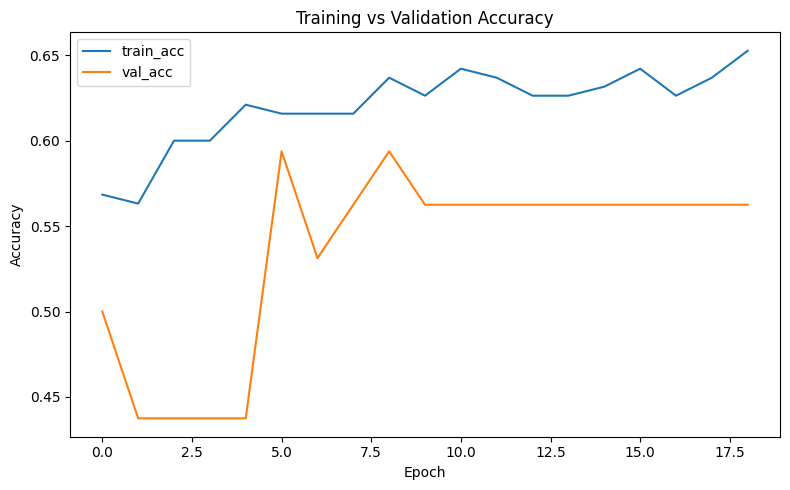

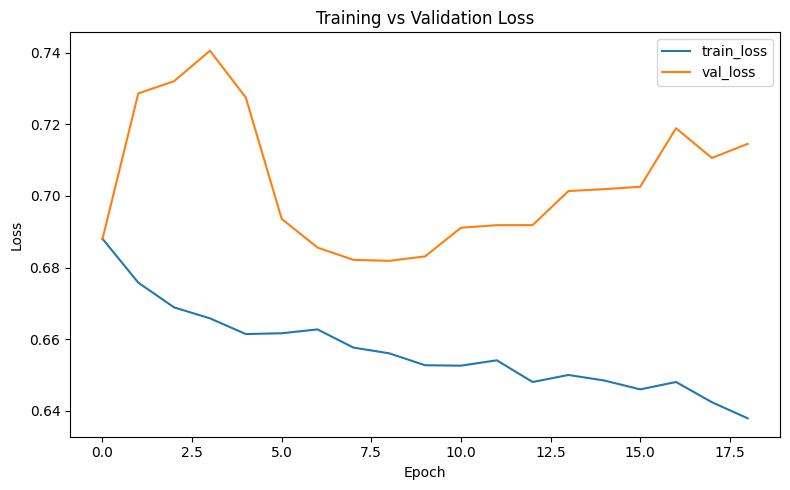

In [ ]:
hist = pd.DataFrame(history.history)

plt.figure(figsize=(8,5))
plt.plot(hist["accuracy"], label="train_acc")
plt.plot(hist["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout(); plt.savefig("figs/accuracy_curve.png", dpi=150)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(hist["loss"], label="train_loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig("figs/loss_curve.png", dpi=150)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== TEST METRICS ===
Accuracy:  0.3438
Precision: 0.6364
Recall:    0.2917
F1-score:  0.4000
ROC-AUC:   0.2656


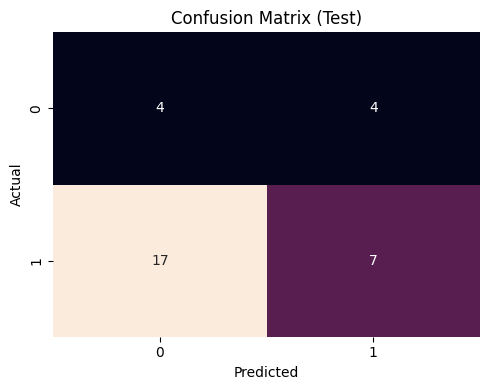

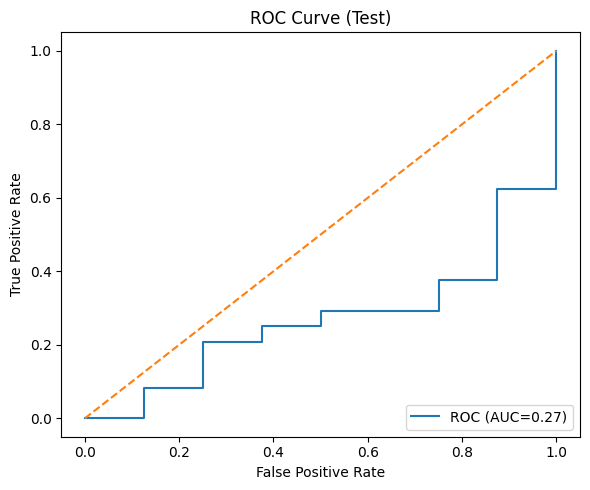


=== CLASSIFICATION REPORT ===
               precision    recall  f1-score   support

           0     0.1905    0.5000    0.2759         8
           1     0.6364    0.2917    0.4000        24

    accuracy                         0.3438        32
   macro avg     0.4134    0.3958    0.3379        32
weighted avg     0.5249    0.3438    0.3690        32



In [ ]:
from sklearn.metrics import roc_curve
import seaborn as sns

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
try:
    roc = roc_auc_score(y_test, y_prob)
except:
    roc = float("nan")

print("\n=== TEST METRICS ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.savefig("figs/confusion_matrix.png", dpi=150)
plt.show()

try:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc:.2f})")
    plt.plot([0,1],[0,1],"--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)"); plt.legend(loc="lower right")
    plt.tight_layout(); plt.savefig("figs/roc_curve.png", dpi=150)
    plt.show()
except Exception as e:
    print("ROC curve skipped:", e)

print("\n=== CLASSIFICATION REPORT ===\n",
      classification_report(y_test, y_pred, digits=4, zero_division=0))


In [ ]:
sample = pd.DataFrame({
    "y_true": y_test[:20],
    "y_prob": np.round(y_prob[:20], 4),
    "y_pred": y_pred[:20]
})
sample


,y_true,y_prob,y_pred
0,0,0.4779,0
1,1,0.4730,0
2,0,0.4671,0
3,1,0.4601,0
4,1,0.4542,0
5,1,0.4489,0
6,1,0.4436,0
7,0,0.4393,0
8,1,0.4345,0
9,1,0.4302,0
